# KUME Con1 Advanced

## 発展　点変異以外にも挿入やDeletionがあるデータ

### 1. 方針

In [ ]:
with open("SequenceA.txt") as f:
    sequenceA = f.read()
with open("SequenceC.txt") as f:
    sequenceC = f.read()

In [ ]:
print(sequenceA[15:30])
print(sequenceC[15:30])

TGCCCTTCTCTCAAC
TGCCATTTCTCTCAA


上のように、挿入(insertion)&欠失(deletion)があるデータを見る場合、変異を検出するにはどのようなアルゴリズムを使うべきでしょう…？

簡単な配列で考えてみると、一筋縄ではいかないことがわかります。例えば、下の二つの配列で考えてみると、どんな変異が起こっていると考えられるでしょうか...？

- 配列1 : ACCGT
- 配列2 : ACGTT

In [ ]:
### 記入欄

このように、簡単な配列でもたくさんの変異の組み合わせがあることが分かります。配列が長くなればなるほど、解釈の可能性は膨大な数になるでしょう。

では、どうすれば「正しい」変異を検出することが出来るでしょうか...？

In [ ]:
### 記入欄

先述の通り解釈の可能性は膨大であり、ヒトゲノムのような億スケールの配列となればすべての可能性を探索することはほぼ不可能に近くなります。

そこで、現実世界で使われている変異検出 (あるいは塩基配列のアラインメント) のソフトウェアでは、配列のマッチングについて以下のような**点数化**を行い、配列同士がどれくらい「近い」かを定量的に評価することで、ありそうな可能性を絞り込んでいるようです。

- 同じ種類の塩基がペアになっていれば $+s$点、異なっていれば$-s$点
- ギャップが1つ生じるごとに$-g$点

このようにルールが複数ある、答えに複数の可能性が考えられる場合は、ルールや答えに対してスコアをつけることが有効な場合があります。

実際の解析では、もう少し複雑な配点ルールが用いられています。また、アミノ酸配列のアラインメントでは、20種類のアミノ酸のペアごとに異なるスコアを割り当てた「スコア表」が用いられているみたいです。(例：[PAM250やBLOSUMなど](https://www.jst.go.jp/nbdc/bird/jinzai/literacy/streaming/h21_3_1.pdf)) ここらへんのスコアがどうやって決まっているかを見るのもおもしろそうですが、とりあえずざっくりとしたアルゴリズムのほうから見ていきましょう。

※注意！※
このノートブックでは変異検出のアルゴリズムを作成する代わりに、**配列アラインメント**決定のアルゴリズムを作成します。
配列アラインメントとは、異なる塩基配列同士の最適な対応関係を求める最適化問題の一種です。これができたら、どこに挿入欠失があって、どこで置換が起こっているかも求まることになります。

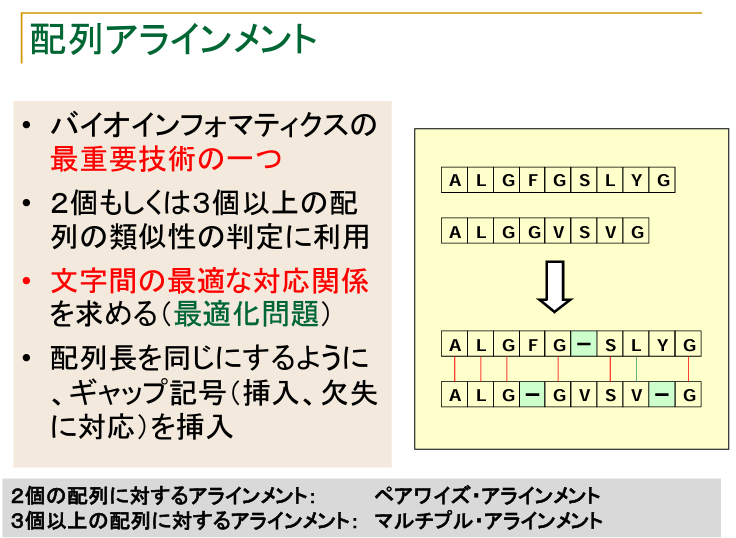

### 2. 配列のスコア化と、その探索アルゴリズム

まずは先述の配列1、配列2を使って、このアルゴリズムで得点を計算してみましょう。初めに配列1の3文字目までの部分鎖と、配列2の3文字目までの部分鎖のスコアを計算してみます。

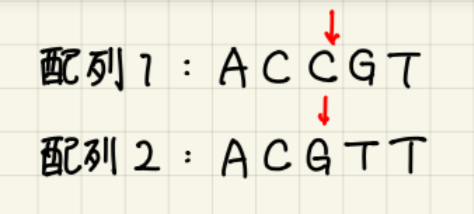

この二つの部分鎖の類似度スコアとして、三つのパターンがあることが分かります。

すなわち、

1. 置換が起こっている (あるいは起こっていない) パターン 
2. 配列2をもとにした時に、配列1で欠失が起こっているパターン
3. 配列2をもとにした時に、配列1で挿入が起こっているパターン 

があり、それぞれの状態遷移パターンについて、類似度スコアを計算することが出来ます。

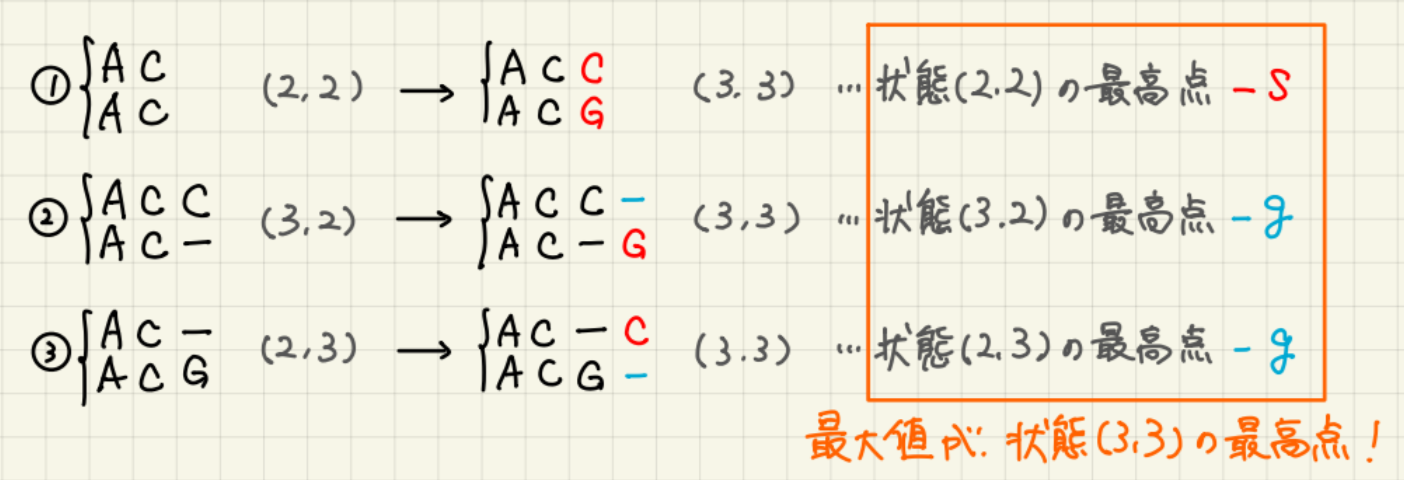

これと同様の方法で考えられる配列1、配列2の部分鎖同士の組み合わせについての類似度スコアを求めていけば、いずれは配列1全体、配列2全体同士の類似度スコアの最大値が求まるというからくりです。

これを一般化してみましょう。二つの塩基配列を$X = {x_1, x_2, ..., x_n}$、$Y = {y_1, y_2, ..., y_n}$とします。$x_i$, $y_j$のそれぞれはA, T, C, Gのいずれかを表しています。

ここで、$X$については$i$番目、$Y$については$j$番目のところまでの「部分鎖」(以下では$(i,j)$とすることにします) についての、アラインメントの最大スコアを$H_{i,j}$と表記することにします。スコアは、アラインメントの整合性の程度を表す数値で、それが大きいほど二つはよく一致していると解釈できます。


その時の部分鎖$(i,j)$は、

- $(i-1,j-1)$に$X$と$Y$の塩基をそれぞれ追加 = 新たな塩基対の追加
- $(i-1,j)$に$X$の塩基を一つ追加 = $Y$にギャップを挿入
- $(i,j-1)$に$Y$の塩基を一つ追加 = $X$にギャップを挿入

の3つの可能性のいずれかから生成されます。

すなわち、$(i,j)$アラインメントの最大スコア$H_{i,j}$は、上記の3通りのパターンのうち、スコア合計が最大になるもの、式で表現すれば、

\begin{equation*}
H_{i,j} = \max\begin{cases}
H_{i-1,j-1}+s_{i,j} \\
H_{i-1,j}-g \\
H_{i,j-1}-g
\end{cases}
\end{equation*}

となります。塩基対のスコアを$s=1$、ギャップのペナルティを$g=2$としてコードを作成してみましょう。

**新項目1：関数の定義**\
ここでは、アラインメントのスコアを計算するコードを関数として作成してみましょう。関数、とは


In [ ]:
def get_score(i, j, x, y, s, g):
    ### 演算
    ### 演算
    ### 演算
    return ### 出力

のような形で、()内に入力値を代入したら、内部で演算を行い出力 (return) を返します。沢山の複雑な演算をたった一単語*get_score*でまとめて行うことが出来るので、様々な入力に対して同様の演算を行う場合に役に立ちます。

この関数では入力を4種類設定します。
- x: 配列x。データ型は文字列(str)
- y: 配列y。データ型は文字列(str)
- i: 配列xの部分鎖の長さ。データ型は整数(int)
- j: 配列yの部分鎖の長さ。データ型は整数(int)

出力は、部分鎖の組み合わせの最大スコア$H$とします。

**新項目2：リスト**\
工事中…

注目すべきポイントは、この関数は数列とみなせるということです。なので、数列と同じように初項 (初期条件) を定義する必要があります。

In [ ]:
# スコア設定
s = 1
g = 2

# スコアの下限
inf = -10000

# 関数作成
def get_score(i, j, x, y):
    global H
    # 初期条件の設定
    if i<=0 or j<=0:
        if i==0 and j==0:
            H[i,j] = 0
        elif i>0 and j==0:
            H[i,j] = get_score(i-1,j,x,y) - g
        elif i==0 and j>0:
            H[i,j] = get_score(i,j-1,x,y) - g
        return H[i,j]
    # 遷移パターンの探索
    else:
        # 既に探索が終了している場合
        if H[i,j] > inf:
            return H[i,j]
        # それ以外
        else:
            # 状態(i-1,j-1)からの遷移
            if x[i-1]==y[j-1]:
                h1 = get_score(i-1,j-1,x,y) + s
            else:
                h1 = get_score(i-1,j-1,x,y) - s
            # 状態(i-1,j)からの遷移
            h2 = get_score(i-1,j,x,y) - g
            # 状態(i,j-1)からの遷移
            h3 = get_score(i,j-1,x,y) - g
            # 最終スコア
            H[i,j] = max(h1, h2, h3)
            return H[i,j]

実際に、先ほどの配列1, 配列2で試してみましょう。

In [ ]:
import numpy as np

X = "ACCGT"
Y = "ACGTT"

N = len(X)
M = len(Y)
# スコアをメモしておくリスト
H = np.full((N+1,M+1), inf, dtype='int16')

print('SCORE=',get_score(N,M,X,Y))

SCORE= 1


うまく計算できているように見えます。ただし、これではどこに挿入・欠失・変異が起こっているのか、実際のアラインメントはどんなものなのかは分かりません。最大スコアとなるアラインメントを提示できるように、この関数を改造してみましょう。

**新項目3：ディクショナリ**\
工事中...

In [ ]:
# スコア設定
s = 1
g = 2

# スコアの下限
inf = -10000

# 関数作成
def get_score_and_array(i, j, x, y):
    global H
    global S
    L = len(y)
    # 初期条件の設定
    if i<=0 or j<=0:
        if i==0 and j==0:
            H[i,j] = 0
            px, py = '', ''
        elif i>0 and j==0:
            score, px, py = get_score_and_array(i-1,j,x,y)
            H[i,j] = score - g
            py = py + '-'
        elif i==0 and j>0:
            score, px, py = get_score_and_array(i,j-1,x,y)
            H[i,j] = score - g
            px = px + '-'
        hash = i * L + j
        S[hash] = (px, py)
        return H[i,j], px, py
    # 遷移パターンの探索
    else:
        # 既に探索が終了している場合
        if H[i,j] > inf:
            px, py = S[i*L+j]
            return H[i,j], px, py
        # それ以外
        else:
            # 状態(i-1,j-1)からの遷移
            h1, px1, py1 = get_score_and_array(i-1,j-1,x,y)
            if x[i-1]==y[j-1]: h1 = h1 + s
            else: h1 = h1 - s
            # 状態(i-1,j)からの遷移
            h2, px2, py2 = get_score_and_array(i-1,j,x,y)
            h2 = h2 - g
            # 状態(i,j-1)からの遷移
            h3, px3, py3 = get_score_and_array(i,j-1,x,y)
            h3 = h3 - g
            # 最終スコア
            H[i,j] = max(h1, h2, h3)
            if h1 == H[i,j]:
                px = px1 + x[i-1]
                py = py1 + y[j-1]
            elif h2 == H[i,j]:
                px = px2 + x[i-1]
                py = py2 + '-'
            else:
                px = px3 + '-'
                py = py3 + y[j-1]
            hash = i * L + j
            S[hash] = (px, py)
            return H[i,j], px, py

In [ ]:
import numpy as np

X = "ACCGT"
Y = "ACGTT"

N = len(X)
M = len(Y)
# スコアをメモしておくリスト
H = np.full((N+1,M+1), inf, dtype='int16')
# 配列をメモしておくディクショナリ
S = {}

score, array1, array2 = get_score_and_array(N,M,X,Y)
print("SCORE: ", score)
print("ARRAY1: ", array1)
print("ARRAY2: ", array2)

SCORE:  1
ARRAY1:  ACCGT
ARRAY2:  ACGTT


うまくいきました！もう少し大きなデータでも試してみましょう！

In [ ]:
import numpy as np

X = sequenceA[15:30]
Y = sequenceC[15:30]

print("SEQUENCE1: ", X)
print("SEQUENCE2: ", Y)

N = len(X)
M = len(Y)
# スコアをメモしておくリスト
H = np.full((N+1,M+1), inf, dtype='int16')
# 配列をメモしておくディクショナリ
S = {}

score, array1, array2 = get_score_and_array(N,M,X,Y)
print("SCORE: ", score)
print("ALIGNMENT1: ", array1)
line = ''
for i in range(len(array1)):
    if array1[i] == array2[i]:
        line = line + '|'
    else:
        line = line + ' '
print("            ", line)
print("ALIGNMENT2: ", array2)

SEQUENCE1:  TGCCCTTCTCTCAAC
SEQUENCE2:  TGCCATTTCTCTCAA
SCORE:  8
ALIGNMENT1:  TGCC-CTTCTCTCAAC
             ||||  ||||||||| 
ALIGNMENT2:  TGCCATTTCTCTCAA-


### 3. 動的計画法 (dynamic programming) - Needleman-Wunsch アルゴリズム

前項では、再帰的な関数を使ってうまく配列アラインメントをすることが出来ることが分かりました。この関数をつかって、sequenceAとsequenceCの550文字目までのアラインメントを行ってみましょう！参考の為に、実行にかかった時間も計測してみます。

In [ ]:
import sys
import time 
import numpy as np

sys.setrecursionlimit(10000)

X = sequenceA[:550]
Y = sequenceC[:550]

print("SEQUENCE1: ", X)
print("SEQUENCE2: ", Y)

N = len(X)
M = len(Y)
# スコアをメモしておくリスト
H = np.full((N+1,M+1), inf, dtype='int16')
# 配列をメモしておくディクショナリ
S = {}

print("===============")
print("ALIGNMENT START")
print("===============")
start = time.time()
score, array1, array2 = get_score_and_array(N,M,X,Y)
end = time.time()
print("ELAPSED TIME: ", round(end-start, 1), 'seconds')
print("SCORE: ", score)
print("ALIGNMENT1: ", array1)
line = ''
for i in range(len(array1)):
    if array1[i] == array2[i]:
        line = line + '|'
    else:
        line = line + ' '
print("            ", line)
print("ALIGNMENT2: ", array2)

SEQUENCE1:  ACGTATGATGCATGGTGCCCTTCTCTCAACTCCACCAGGGAGATCTCTGCGTTAGCCCGAAGACAACCATCACTGGTTTTCCGCCAAGTGCTAGACAGGTATGTGCGCCAGATCTTTCCGGCCCGTCTCGGGTCGGAAGGTCACGACGTAAATCGTACAGAACGAAGTGCCTTACCAACGGGACTGGGGCCGCTGTACATCACAGCCGTGTGTGCCTGCGGCTGACGTGCTTCCCGTGCGTTCACCCGAACGGGCCAGAAGGCTCCGTGGAAGAAGTTTTCCTGGAGACCCAGCGGTGCATACTCCACGCCTTAACTTTACAATGGAGCGCGCTGCAGAAGGATGACGTACGTAGCTGCTATTTAAGGGTGGTATAATTTGAGGCAGCCGTGTGGCCCTCTTGAACTAGAGTCCTAAAACCTATCACGTACAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGCAGGCCCCAGAGACATGTTCATACCAC
SEQUENCE2:  ACGTATGATGCATGGTGCCATTTCTCTCAACTCCACCATGGAGATCTTTGCGTTAGCCCGAATACAACCATCACTGGTTTTCCGCCAAGTCCTAGACAGGTAGGTGCGAAAGCTCTTTCCGGCCCGTCTCGGGTCGGAAGGTCACGACTTAAATCGTACAGAACGAAGTGCCCTACCAACTGGACTGGGCCGCTGTCCATCACAGCCGTGTGTGCCTGCGGCTGACTTGCTTCCCGTACGTTAACCCGAACGGGCCAGAAGTCTCCGTGGAAGAAGTTGTCCTGGAGACCCAGCGGTGCATACTCCACGCCTAAACCTTACAATGGAGCGCGCTGCAGAAGGATGACGTACGTAGCTACTATTTAAGGGTCTATATAATTTGAGGCAGCACGTGTGGCCCTCTTGAACTAGAGTCCCAAAACCTA

時間がかかってしまいました(配列全体で解析しようとすると、1時間以上かかります)...これでは人間がやったほうがはやいまでありそうです。

どうしてこんなに時間がかかってしまったのでしょうか...？原因は、**再帰関数がものすごく無駄の多い計算をしている**ことにあります。簡単のために、有名な再帰関数であるフィボナッチ数列で考えてみましょう。

In [ ]:
### フィボナッチ数列の第n項を求める関数を作成します

def fib(n):
    if n == 1:
        return 1
    elif n == 2:
        return 2
    else:
        return fib(n-1) + fib(n-2)

せっかく作成したので、フィボナッチ数列の第20項を求めてみましょう。

In [ ]:
### 第20項を求めます。実行時間も計測してみましょう。

start = time.time()
print(fib(20))
end = time.time()
print("ELAPSED TIME: ", round(start-end, 1), "seconds")

やはりだいぶ時間がかかってしまいました。関数の内部で行われている演算を、図にしてみてみましょう。

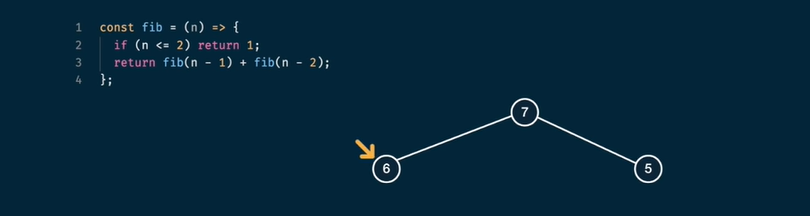

上のように、第7項の計算を⑦、第6項の計算を⑥...として、⑦がどのように関数を呼び出しているかを図式化していきます。そうすると、次のように木のような構造が得られることが分かります。

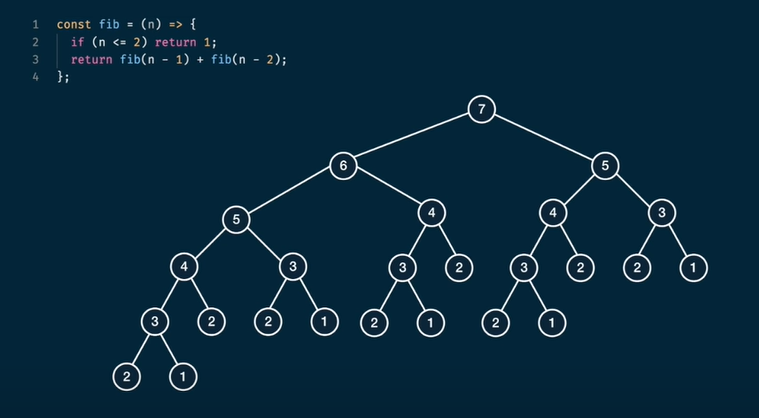

第7項の演算では、上の木のすべてのノード (〇) の関数を呼び出していることになります。ここで、この木の中に似たような部分構造が沢山あることが分かります。例えば、③を頂点とする木を見てみましょう。⑦ツリーのなかに、たくさんの③ツリーが隠れています。

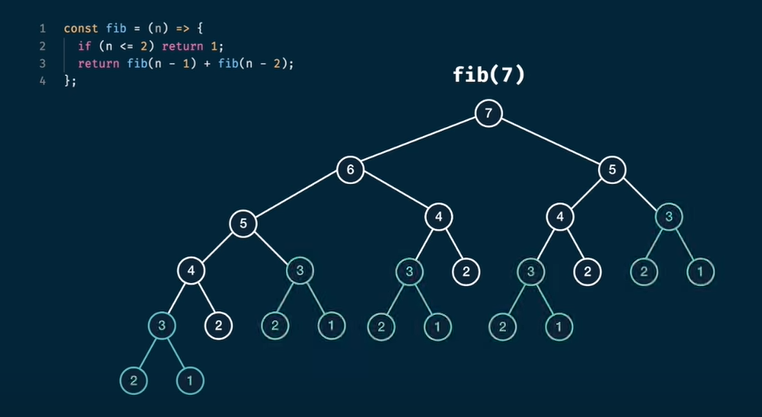

今の再帰的な関数では、これらの③ツリーを毎回毎回計算していることになります。すでに計算したことがあって答えが分かっているのにまた同じ計算を繰り返すのは、アルゴリズム的にはあまり効率的とは言えません。そこで、一回計算したものに関しては答えをメモしておく、ということを考えます。

工事中...

In [ ]:
N = len(X)
M = len(Y)

gap_penalty = -2

H = np.empty((N+1,M+1), dtype='int16')
L = np.zeros((N+1,M+1), dtype='int8')

H[0,0]=0
for j in range(1,M+1):
    H[0,j] = H[0,j-1] + gap_penalty
    L[0,j] = 0
    
for i in range(1,N+1):
    H[i,0] = H[i-1,0] + gap_penalty
    L[i,0] = 2

# Horizontal:0 Diagonal:1 Vertical:2
s = np.array([0,0,0],dtype='int')

for i in range(1,N+1):
    for j in range (1,M+1):
        s[0] = H[i,j-1] + gap_penalty
        
        if X[i-1]==Y[j-1]:
            score = +1
        else:
            score = -1
        s[1] = H[i-1,j-1] + score
        
        s[2] = H[i-1,j] + gap_penalty
        
        H[i,j]=np.max(s)
        L[i,j]=np.argmax(s)



pairs=[ ]
i=N
j=M
while i!=0 or j!=0:
    if L[i,j]==0:
        pairs.append( ["-",Y[j-1]] )
        j=j-1
    elif L[i,j]==1:
        pairs.append( [X[i-1],Y[j-1]] )
        i=i-1
        j=j-1
    else:
        pairs.append( [X[i-1],"-"] )
        i=i-1

pairs.reverse()

print('SCORE=', H[N,M])

for p in pairs:
    print(p[0],end='')
print()

for p in pairs:
    if p[0]==p[1]:
        print('|',end='')
    else:
        print(' ',end='')
print()


for p in pairs:
    print(p[1],end='')
print()

## 配列解析の応用例

遺伝子配列解析は、めちゃくちゃ重要な技術です。基礎研究で使用される大体の手法は、これがベースとなっている気がします。PCR、GWAS、次世代シーケンサーなど...？ていうか配列解析に使うDNAとかってどうやって作ってるの&どうやって抽出してるの...？

最近の話題であれば、2022年ノーベル生理学・医学賞を受賞したウィリアム・ペーボのネアンデルタール人のゲノム解析などは、すごくこの技術を使っていそうです。

## 参考文献

1. [東北大学 早川美徳先生のサイト](https://wagtail.cds.tohoku.ac.jp/coda/python/p-8-function-part2-sup-seq-alignment.html)
2. [京都大学 阿久津達也先生の講義スライド](https://www.bic.kyoto-u.ac.jp/takutsu/members/takutsu/sysbioinfo2019b.pdf)
3. [奈良先端科学技術大学院 川端猛先生の講義スライド](https://www.jst.go.jp/nbdc/bird/jinzai/literacy/streaming/h21_3_1.pdf)
4. [Youtube-freeCodeCamp dynamic programming](https://www.youtube.com/watch?v=oBt53YbR9Kk&t=2359s)
5. [Youtube-Bioinfomatica Needleman-Wunsch algorithm](https://www.youtube.com/watch?v=ipp-pNRIp4g)
6. [Youtube-速水桃子研究室 グラフ理論について](https://www.youtube.com/@hayamizu)
7. [2022年ノーベル生理学・医学賞 ウィリアム・ペーボの研究](https://www.nikkei-science.com/?p=68165)